# Explore here

## Step 1: Problem statement and data collection

Problem statement: given sociodemographic and health resource data have been collected by county in the United States, find out if there is any relationship between health resources and sociodemographic data

In [38]:
# Import dataset to start working with it
import pandas as pd

raw_data = pd.read_csv("../data/raw/demographic_health_data.csv", sep=",")

## Step 2: Exploration and data cleaning

In [39]:
print(f"Raw data shape: {raw_data.shape}")
print(raw_data.info(show_counts=True))

#.info won't make it so easy to find nulls now that we're looking at larger datasets, so let's try other methods...
missing_summary = (
    raw_data.isna().sum()                         # raw counts
      .to_frame('null_count')
      .assign(null_pct=lambda s: s['null_count'].div(len(raw_data))*100)
      .query('null_count > 0')              # keep only problem columns
      .sort_values('null_pct', ascending=False)
)

missing_summary.head(10).style.bar('null_pct')

Raw data shape: (3140, 108)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB
None


Doesn't look as though any of our columns have missing data at all, which simplifies matters.

I'm going to make the simplified assumption that any rows which have identical values across all columns are duplicates of the same county, rather than being actually-distinct counties with so-similar statistics.
I'm also going to make the assumption that FIPS codes are unique by county, and once a first instance is found of a row with a FIPS code, subsequent rows using the same code are to be treated as duped or invalid data. 

In [40]:
raw_data.drop_duplicates(inplace=True)
raw_data = raw_data.drop_duplicates(subset=["fips"], keep="first", ignore_index=True)


print(raw_data.shape)
raw_data.head()
raw_data.info()

(3140, 108)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


### Removing irrelevant data:

- Based on discussion with professor, my instinct is correct that FIPS codes in this context operate as categorical rather than numerical variables.  With only 3000 rows, that's not likely enough data to effectively train the model at so-granular a level as county; sounds like we'd be better off going coarser grouping by state-level rather than county-level.

In [41]:
# remove data considered irrelevant
raw_data.drop(
   ["fips", "CNTY_FIPS", "COUNTY_NAME", "STATE_FIPS"],
   axis=1,
   inplace=True,
)



raw_data.head()

TOT_POP    0-9  0-9 y/o % of total pop  19-Oct  10-19 y/o % of total pop  \
0    55601   6787               12.206615    7637                 13.735364   
1   218022  24757               11.355276   26913                 12.344167   
2    24881   2732               10.980266    2960                 11.896628   
3    22400   2456               10.964286    2596                 11.589286   
4    57840   7095               12.266598    7570                 13.087828   

   20-29  20-29 y/o % of total pop  30-39  30-39 y/o % of total pop  40-49  \
0   6878                 12.370281   7089                 12.749771   7582   
1  23579                 10.814964  25213                 11.564429  27338   
2   3268                 13.134520   3201                 12.865239   3074   
3   3029                 13.522321   3113                 13.897321   3038   
4   6742                 11.656293   6884                 11.901798   7474   

   ...  COPD_number  diabetes_prevalence  diabetes_Lower 95% CI  \
0  ...         3644                 12.9                   11.9   
1  ...        14692                 12.0                   11.0   
2  ...         2373                 19.7                   18.6   
3  ...         1789                 14.1                   13.2   
4  ...         4661                 13.5                   12.6   

   diabetes_Upper 95% CI  diabetes_number  CKD_prevalence  CKD_Lower 95% CI  \
0                   13.8             5462             3.1               2.9   
1                   13.1            20520             3.2               3.0   
2                   20.6             3870             4.5               4.2   
3                   14.9             2511             3.3               3.1   
4                   14.5             6017             3.4               3.2   

   CKD_Upper 95% CI  CKD_number  Urban_rural_code  
0               3.3        1326                 3  
1               3.5        5479                 4  
2               4.8         887                 6  
3               3.6         595                 2  
4               3.7        1507                 2  

[5 rows x 104 columns]

In [42]:
# --- load both artefacts -----------------------------------------------------
dict_df    = pd.read_csv("../data/data_dict.csv", sep=",")

# --- pull the “authoritative” list of names from the first column -----------
# • .iloc[:, 0]  → first column, regardless of its header  
# • .astype(str).str.strip()  → normalise just in case there’s
#   stray whitespace or non-string types
dict_cols  = dict_df.iloc[:, 0].astype(str).str.strip()
dict_index = pd.Index(dict_cols)

# --- 1.  Columns that appear in the data set but are NOT in the dictionary --
missing_from_dictionary = raw_data.columns.difference(dict_index, sort=False)

# --- 2.  (optional) Dictionary entries that don’t exist in the data set -----
unused_dictionary_rows  = dict_index.difference(raw_data.columns, sort=False)

print("Data columns lacking a dictionary entry:", list(missing_from_dictionary))
print("Dictionary rows that map to no data:",    list(unused_dictionary_rows))


Data columns lacking a dictionary entry: ['19-Oct', 'POP_ESTIMATE_2018', 'Median_Household_Income_2018', 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)', 'Total Population', 'STATE_NAME']
Dictionary rows that map to no data: ['fips', "10-19'", 'STATE_FIPS', 'nan']


Looks like the original dataset has a misnamed column, likely at some point mangled by MS Excel: "19-Oct" is an interpretation of "19-10," and this column is immediately between the 0-9 age-range column and the 10-19 y/o % of total pop column.  Shall rename it to 10-19 instead.
The rest of the columns appear intuitive-enough and plausibly relevant-enough to keep.

In [43]:
raw_data.rename(columns={"19-Oct":"10-19"})

TOT_POP    0-9  0-9 y/o % of total pop  10-19  10-19 y/o % of total pop  \
0       55601   6787               12.206615   7637                 13.735364   
1      218022  24757               11.355276  26913                 12.344167   
2       24881   2732               10.980266   2960                 11.896628   
3       22400   2456               10.964286   2596                 11.589286   
4       57840   7095               12.266598   7570                 13.087828   
...       ...    ...                     ...    ...                       ...   
3135    43051   6104               14.178532   6326                 14.694200   
3136    23081   2384               10.328842   2185                  9.466661   
3137    20299   3121               15.375142   3205                 15.788955   
3138     7885    858               10.881420   1113                 14.115409   
3139     6967    780               11.195637    779                 11.181283   

      20-29  20-29 y/o % of total pop  30-39  30-39 y/o % of total pop  40-49  \
0      6878                 12.370281   7089                 12.749771   7582   
1     23579                 10.814964  25213                 11.564429  27338   
2      3268                 13.134520   3201                 12.865239   3074   
3      3029                 13.522321   3113                 13.897321   3038   
4      6742                 11.656293   6884                 11.901798   7474   
...     ...                       ...    ...                       ...    ...   
3135   5359                 12.448027   6577                 15.277229   5334   
3136   2967                 12.854729   4093                 17.733200   3423   
3137   2153                 10.606434   2702                 13.311001   2390   
3138    715                  9.067850    903                 11.452124    900   
3139    681                  9.774652    906                 13.004162    734   

      ...  COPD_number  diabetes_prevalence  diabetes_Lower 95% CI  \
0     ...         3644                 12.9                   11.9   
1     ...        14692                 12.0                   11.0   
2     ...         2373                 19.7                   18.6   
3     ...         1789                 14.1                   13.2   
4     ...         4661                 13.5                   12.6   
...   ...          ...                  ...                    ...   
3135  ...         2098                  8.9                    8.3   
3136  ...          928                  7.2                    6.5   
3137  ...         1163                 10.4                    9.5   
3138  ...          506                 11.3                   10.3   
3139  ...          480                 11.7                   10.7   

      diabetes_Upper 95% CI  diabetes_number  CKD_prevalence  \
0                      13.8             5462             3.1   
1                      13.1            20520             3.2   
2                      20.6             3870             4.5   
3                      14.9             2511             3.3   
4                      14.5             6017             3.4   
...                     ...              ...             ...   
3135                    9.6             2834             2.6   
3136                    8.0             1360             2.4   
3137                   11.2             1500             3.0   
3138                   12.1              686             3.4   
3139                   12.7              644             3.4   

      CKD_Lower 95% CI  CKD_Upper 95% CI  CKD_number  Urban_rural_code  
0                  2.9               3.3        1326                 3  
1                  3.0               3.5        5479                 4  
2                  4.2               4.8         887                 6  
3                  3.1               3.6         595                 2  
4                  3.2               3.7        1507                 2  
...         

## Step 3: Analysis of univariate variables
### categorical variables
Categorical, non-numeric variables in this dataframe include: county-level fips (which we just deleted), STATE_NAME, and Urban_rural_code

In [44]:
categorical_variables = [
    "STATE_NAME",
    "Urban_rural_code",
]

for each_categorical_variable in categorical_variables:
    print(f"\n\t{each_categorical_variable}s:")
    for each_possible_value in sorted(
        raw_data[f"{each_categorical_variable}"].unique()
    ):
        print(each_possible_value)


	STATE_NAMEs:
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming

	Urban_rural_codes:
1
2
3
4
5
6


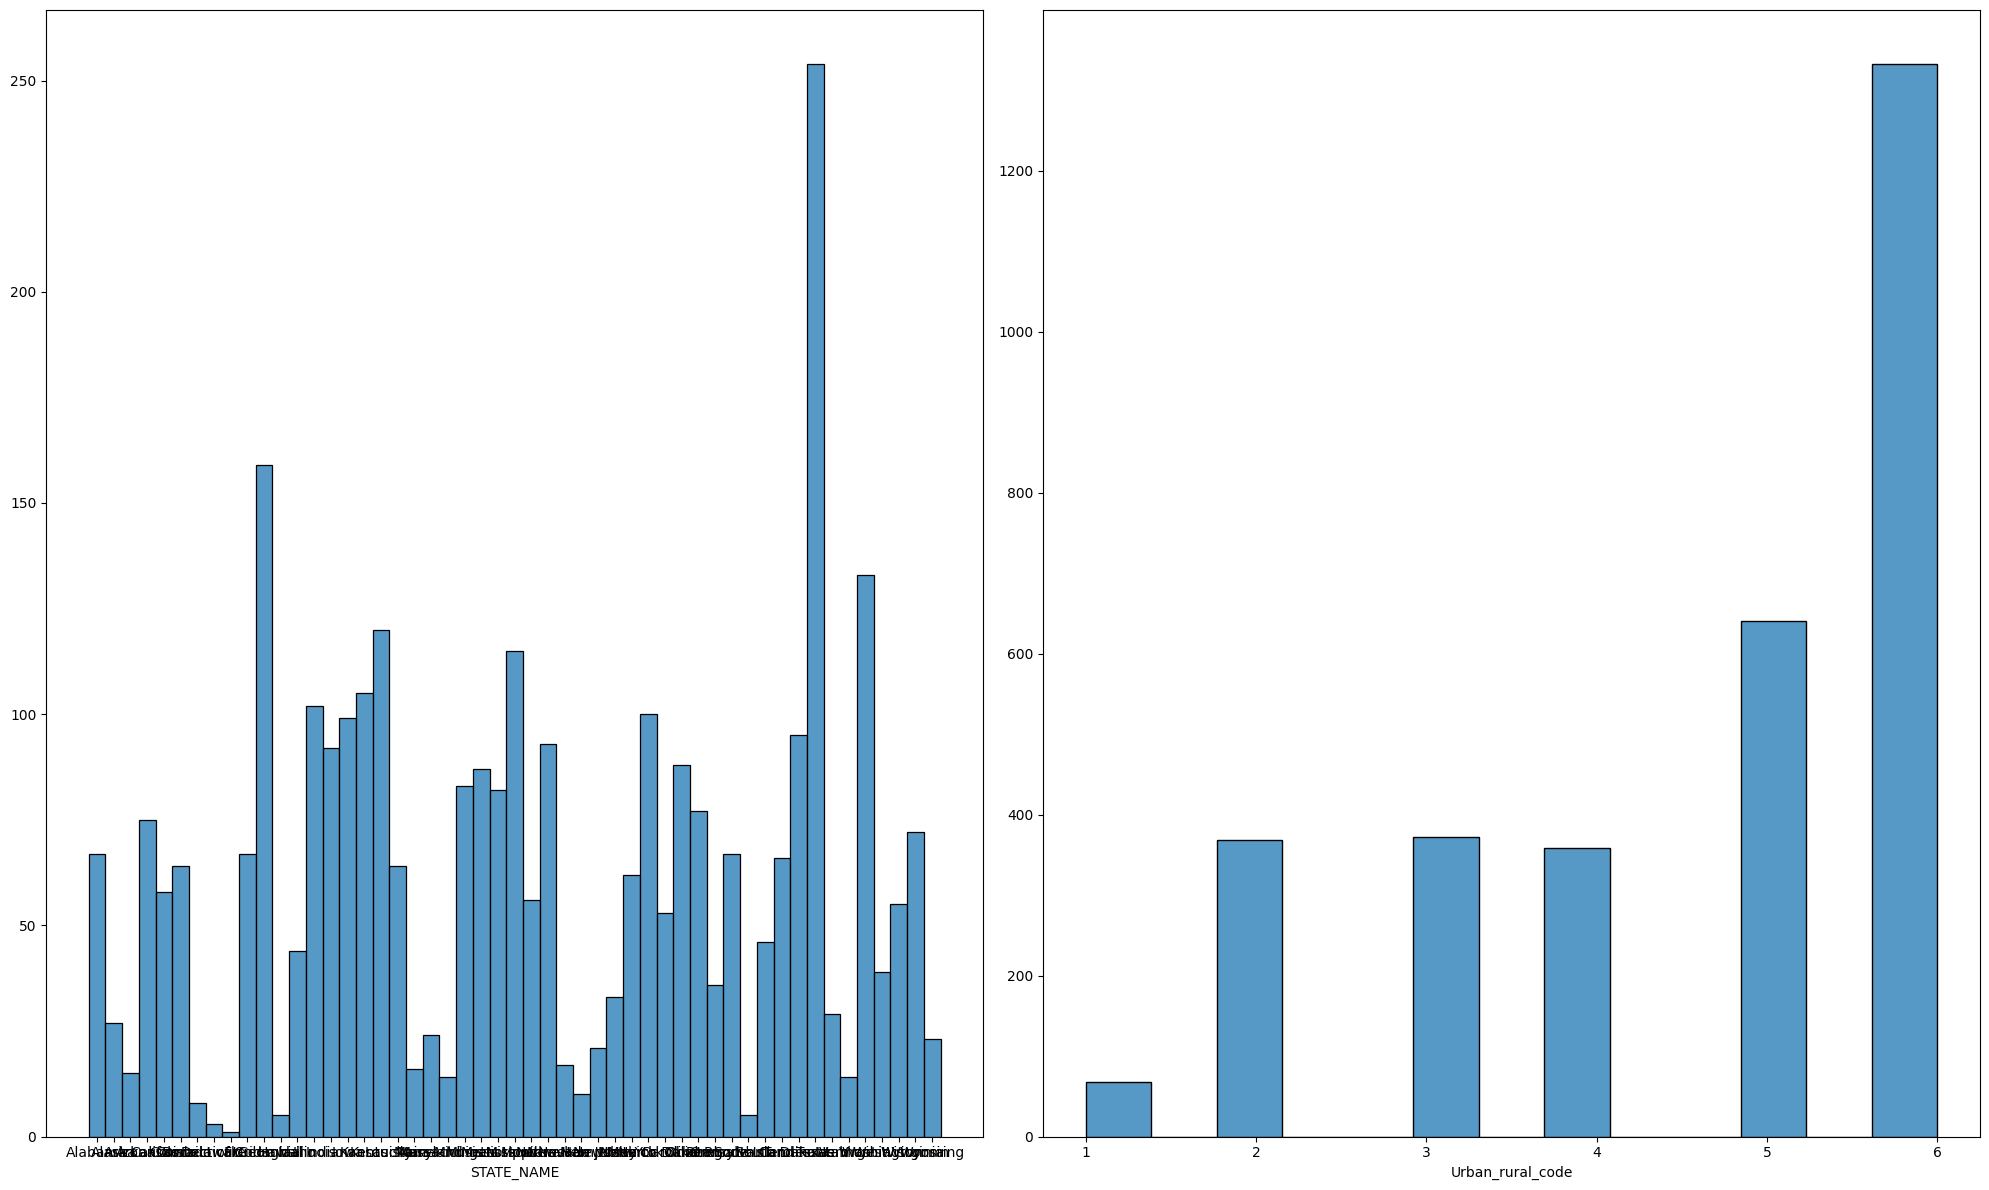

In [ ]:
# histogram-plot each categorical variable

import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(1, 2, figsize=(20, 12))

# Create a multiple histogram
sns.histplot(ax=axis[0], data=raw_data, x="STATE_NAME", bins="auto").set(ylabel=None)
sns.histplot(ax=axis[1], data=raw_data, x="Urban_rural_code").set(ylabel=None)

# Adjust the layout
plt.tight_layout()
plt.xticks(rotation=90)

# Show the plot
plt.show()

- We have many more counties worth of data available for some states than others; almost all are between 100 and 350 but the extrmes range from the tens all the way up to over 450 
- Despite data dictionary including codings above 6 we don't appear to have any instances of them in the data.
- Most counties have populations between 2,500 and 19,999 

### numeric variables

Numerical, non-categorical variables in the dataset: vast majority of them, just need to mask out a couple of categorical ones

In [46]:
numeric_variables = raw_data.columns[~raw_data.columns.isin(categorical_variables)] 
print(numeric_variables)

Index(['TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct',
       '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop',
       '30-39', '30-39 y/o % of total pop', '40-49',
       ...
       'COPD_Upper 95% CI', 'COPD_number', 'diabetes_prevalence',
       'diabetes_Lower 95% CI', 'diabetes_Upper 95% CI', 'diabetes_number',
       'CKD_prevalence', 'CKD_Lower 95% CI', 'CKD_Upper 95% CI', 'CKD_number'],
      dtype='object', length=102)


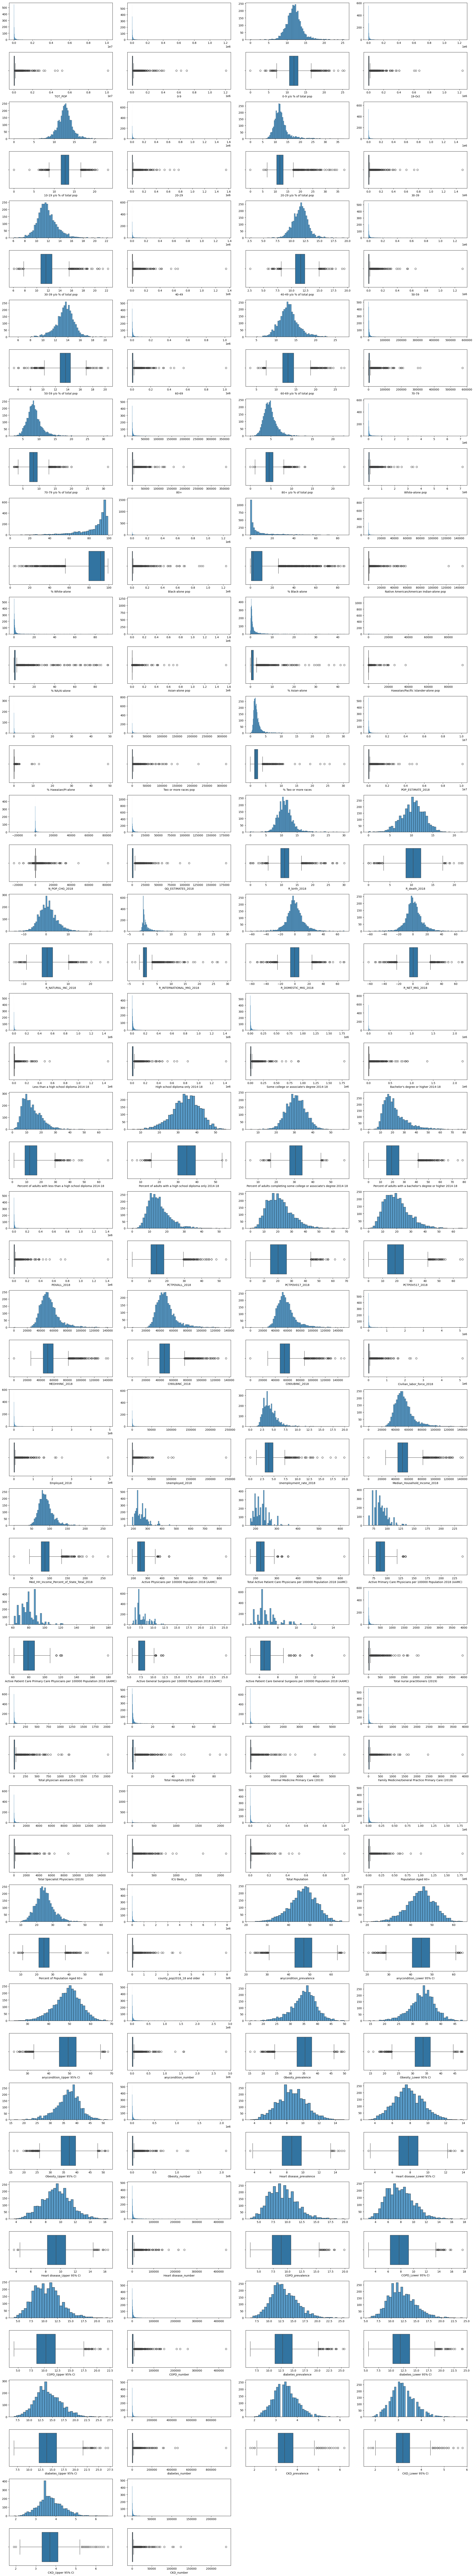

In [47]:
import math

cols_per_row = 4
num_vars = len(numeric_variables)
num_cols = cols_per_row
num_var_rows = math.ceil(num_vars / cols_per_row)
num_rows = 2 * num_var_rows  # 2 rows per variable group (hist + box)

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=(6 * num_cols, 2.5 * num_rows),  # Adjusts spacing
    squeeze=False
)

# Plot
for i, var in enumerate(numeric_variables):
    row_group = i // cols_per_row
    col = i % cols_per_row

    # Histogram in upper of the two rows for this group
    sns.histplot(
        ax=axes[2 * row_group][col],
        data=raw_data,
        x=var
    ).set(xlabel=None, ylabel=None)

    # Boxplot in lower of the two rows for this group
    sns.boxplot(
        ax=axes[2 * row_group + 1][col],
        data=raw_data,
        x=var
    )

# Turn off any unused subplots
for row in axes:
    for ax in row:
        if not ax.has_data():
            ax.set_visible(False)

plt.tight_layout()
plt.show()

From this it looks like:
- plots showing number of people in each age/generation bracket show most counties have a have at most a few hundred thousand people in each age bracket, but then there are outlier counties with over a million (1e6) or a million and a half people in that age bracket.
- proportiohnally, most counties have about even proportions of most age brackets, about 10% or so. Exceptions include a handful of percentage points more 30-39 year olds and a handful of percentage points fewer of older people 70-79 and yet fewer 80+
- Would be curious to hear whether the county with (outlier) zero unemployment did indeed accomplish that or whether it's inaccurate & should be dropped from the dataset.
- Skimming these plots is the point at which I discovered our dataset does include county name and state name for each row.  That isn't shown in the data dictinary.  So I went back up this notebook to delete the county name for the same reason we deleted the county-level fips code earlier, and delete state-level fips code in favor of state name -- both for legibility and to make it that much clearer it's a categorical variable we will factorize later instead of being a numerical veriable.  Also moved my "does the data dictionary really tell us about all the columns?" investigation further up this notebook.

In [48]:
raw_data

TOT_POP    0-9  0-9 y/o % of total pop  19-Oct  \
0       55601   6787               12.206615    7637   
1      218022  24757               11.355276   26913   
2       24881   2732               10.980266    2960   
3       22400   2456               10.964286    2596   
4       57840   7095               12.266598    7570   
...       ...    ...                     ...     ...   
3135    43051   6104               14.178532    6326   
3136    23081   2384               10.328842    2185   
3137    20299   3121               15.375142    3205   
3138     7885    858               10.881420    1113   
3139     6967    780               11.195637     779   

      10-19 y/o % of total pop  20-29  20-29 y/o % of total pop  30-39  \
0                    13.735364   6878                 12.370281   7089   
1                    12.344167  23579                 10.814964  25213   
2                    11.896628   3268                 13.134520   3201   
3                    11.589286   3029                 13.522321   3113   
4                    13.087828   6742                 11.656293   6884   
...                        ...    ...                       ...    ...   
3135                 14.694200   5359                 12.448027   6577   
3136                  9.466661   2967                 12.854729   4093   
3137                 15.788955   2153                 10.606434   2702   
3138                 14.115409    715                  9.067850    903   
3139                 11.181283    681                  9.774652    906   

      30-39 y/o % of total pop  40-49  ...  COPD_number  diabetes_prevalence  \
0                    12.749771   7582  ...         3644                 12.9   
1                    11.564429  27338  ...        14692                 12.0   
2                    12.865239   3074  ...         2373                 19.7   
3                    13.897321   3038  ...         1789                 14.1   
4                    11.901798   7474  ...         4661                 13.5   
...                        ...    ...  ...          ...                  ...   
3135                 15.277229   5334  ...         2098                  8.9   
3136                 17.733200   3423  ...          928                  7.2   
3137                 13.311001   2390  ...         1163                 10.4   
3138                 11.452124    900  ...          506                 11.3   
3139                 13.004162    734  ...          480                 11.7   

      diabetes_Lower 95% CI  diabetes_Upper 95% CI  diabetes_number  \
0                      11.9                   13.8             5462   
1                      11.0                   13.1            20520   
2                      18.6                   20.6             3870   
3                      13.2                   14.9             2511   
4                      12.6                   14.5             6017   
...                     ...                    ...              ...   
3135                    8.3                    9.6             2834   
3136                    6.5                    8.0             1360   
3137                    9.5                   11.2             1500   
3138                   10.3                   12.1              686   
3139                   10.7                   12.7              644   

      CKD_prevalence  CKD_Lower 95% CI  CKD_Upper 95% CI  CKD_number  \
0                3.1               2.9               3.3        1326   
1                3.2               3.0               3.5        5479   
2                4.5               4.2               4.8         887   
3                3.3               3.1               3.6         595   
4                3.4               3.2               3.7        1507   
...              ...               ...               ...         ...   
3135             2.6               2.4               2.8         821   
3136             2.4               2.2               2

## Step 4: Analysis of multivariate variables
### Numerical-numerical analysis
Am curious to see whether/how there are correlations between age & how long people stayed on the phone, or age & how many employees they have.


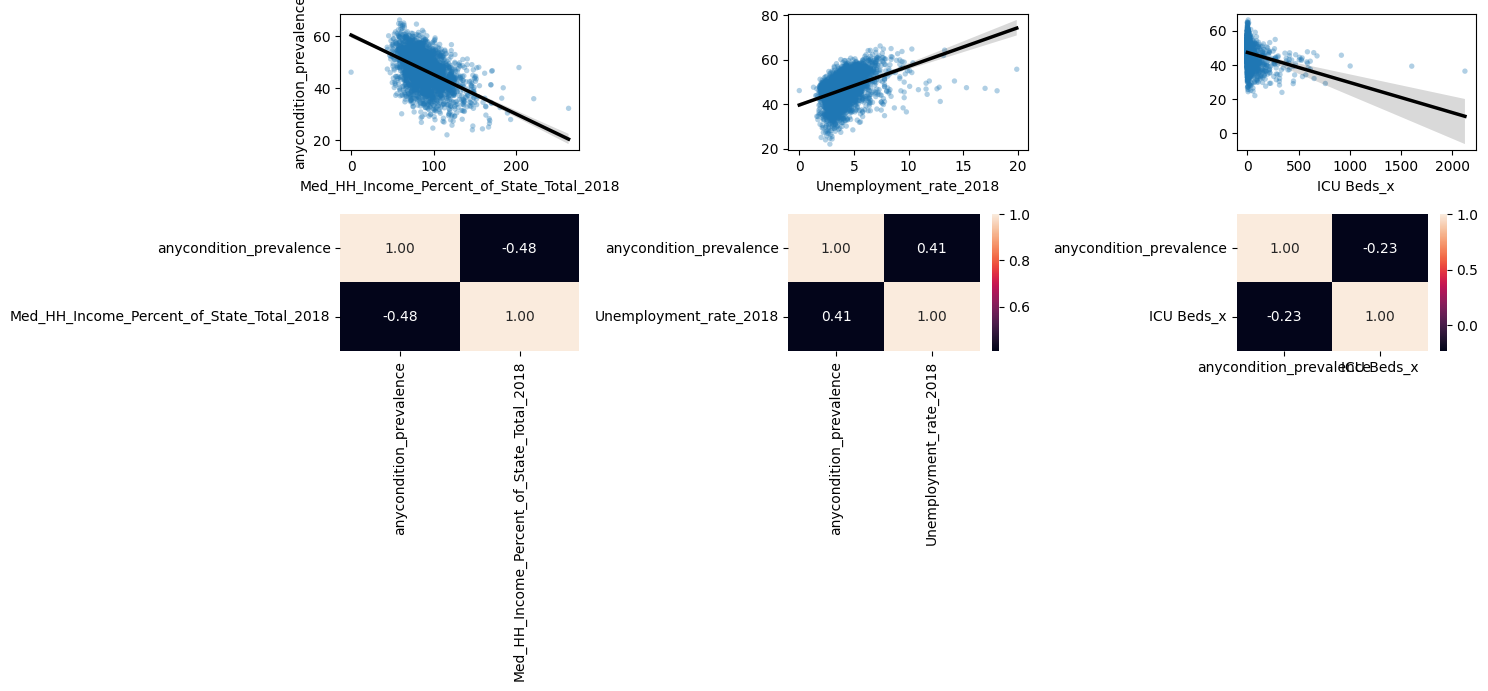

In [ ]:
fig, axis = plt.subplots(2, 3, figsize=(15, 12))

# Create a multiple scatter diagram
common_scatter = {"s": 15, "alpha": 0.35, "edgecolor": "none"}
common_line = {"color": "black", "lw": 2.5, "zorder": 5}

sns.regplot(
    ax=axis[0, 0],
    data=raw_data,
    x="Med_HH_Income_Percent_of_State_Total_2018",
    y="anycondition_prevalence",
    scatter_kws=common_scatter,
    line_kws=common_line,
)
sns.heatmap(
    raw_data[["anycondition_prevalence", "Med_HH_Income_Percent_of_State_Total_2018"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 0],
    cbar=False,
)

sns.regplot(
    ax=axis[0, 1],
    data=raw_data,
    x="Unemployment_rate_2018",
    y="anycondition_prevalence",
    scatter_kws=common_scatter,
    line_kws=common_line,
).set(ylabel=None)
sns.heatmap(
    raw_data[["anycondition_prevalence", "Unemployment_rate_2018"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 1],
)

sns.regplot(
    ax=axis[0, 2],
    data=raw_data,
    x="ICU Beds_x",
    y="anycondition_prevalence",
    scatter_kws=common_scatter,
    line_kws=common_line,
).set(ylabel=None)
sns.heatmap(
    raw_data[["anycondition_prevalence", "ICU Beds_x"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 2],
)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

I had guessed that earning more money corresponds to lower prevalence of unwanted medical health conditions, that higher unemployment corresponds to higher prevalence of such conditions, and that more total ICU beds available leads to lower prevalnence of medical conditions.  the charts make each of these guesses look correct.

### categorical-categorical analysis

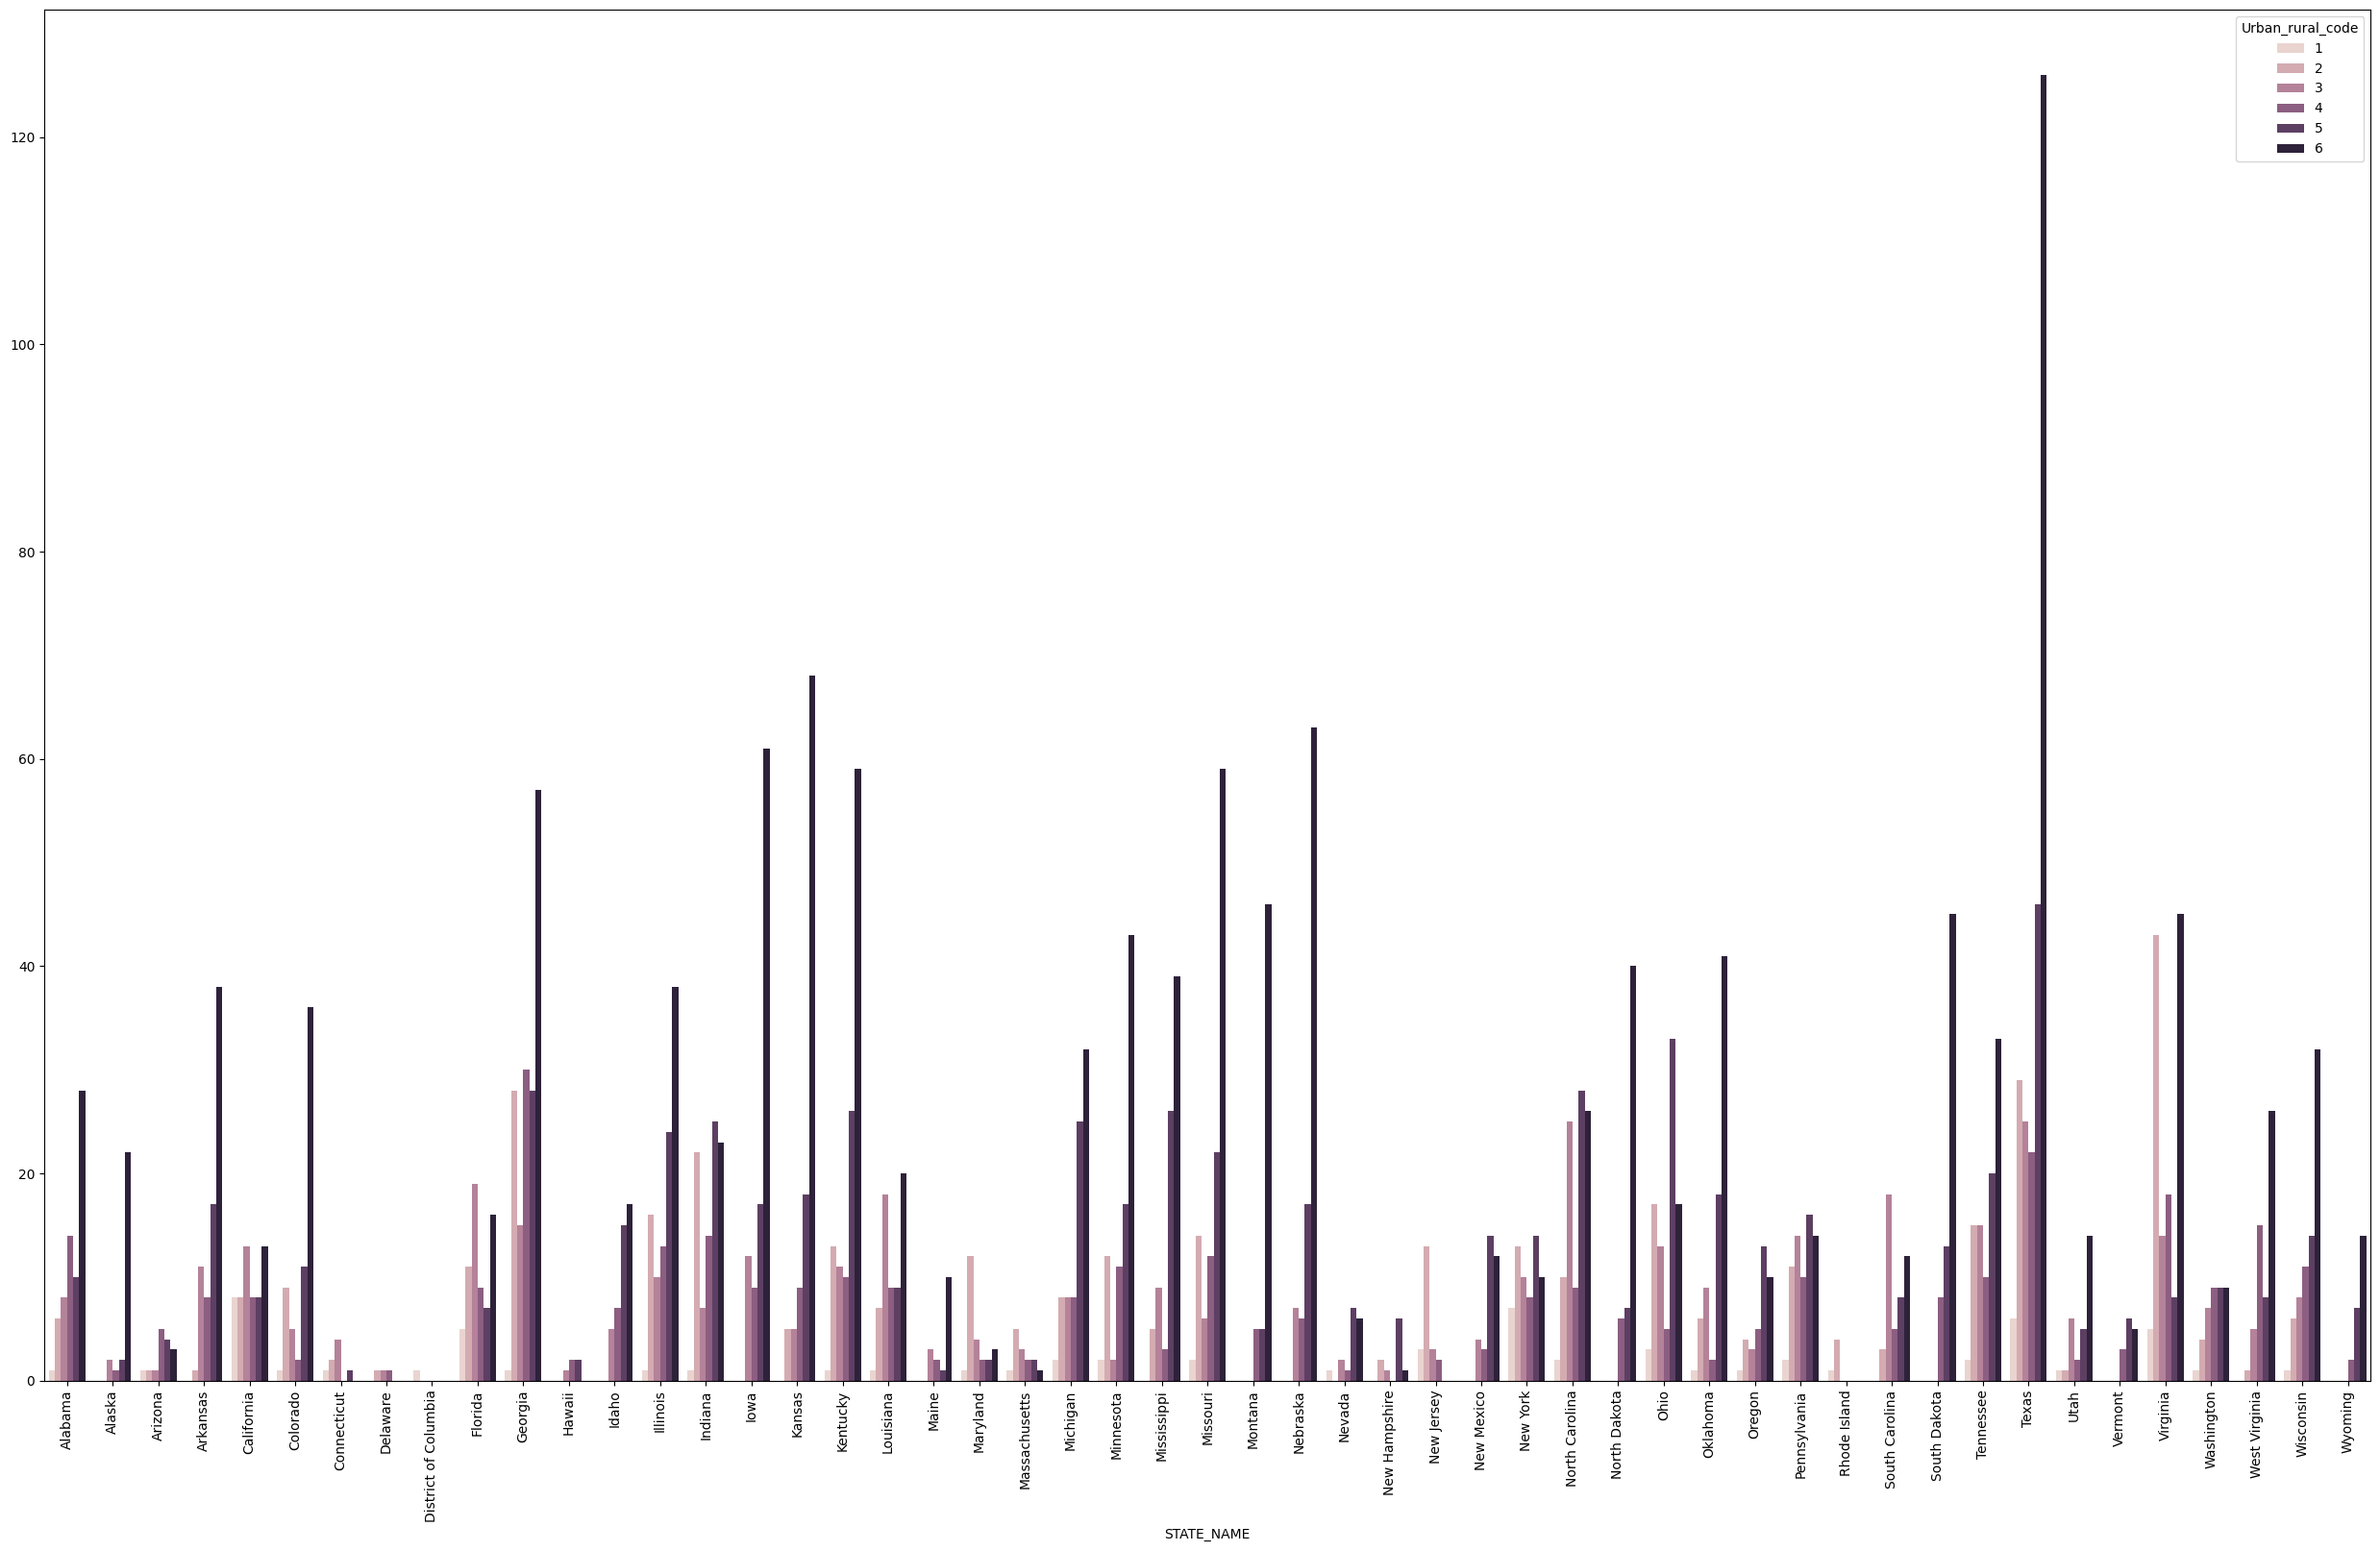

In [61]:
fig, axis = plt.subplots(1, 1, figsize=(25, 15))


sns.countplot(
    data=raw_data,
    x=categorical_variables[0],
    hue="Urban_rural_code",
).set(ylabel=None)

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

There are few enough categorical variableds here that we don't have more plots in this section.  Pretty intuitive to see Rhode Island has few if any large-population counties & Texas has plenty more people adjacent to cities.

#### Correlation analysis


['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


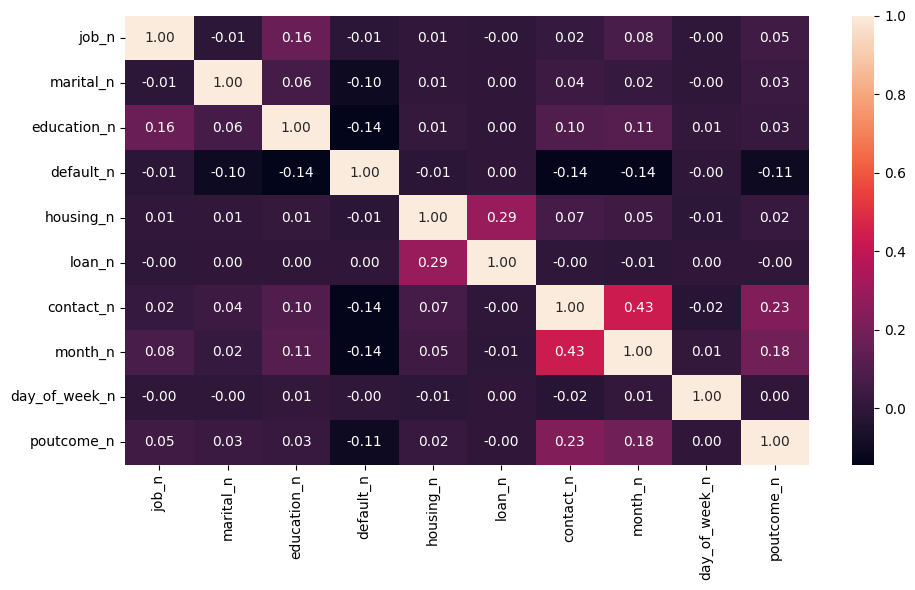

In [ ]:
print(categorical_variables)
raw_data["job_n"] = pd.factorize(raw_data["job"])[0]
raw_data["marital_n"] = pd.factorize(raw_data["marital"])[0]
raw_data["education_n"] = pd.factorize(raw_data["education"])[0]
raw_data["default_n"] = pd.factorize(raw_data["default"])[0]
raw_data["housing_n"] = pd.factorize(raw_data["housing"])[0]
raw_data["loan_n"] = pd.factorize(raw_data["loan"])[0]
raw_data["contact_n"] = pd.factorize(raw_data["contact"])[0]
raw_data["month_n"] = pd.factorize(raw_data["month"])[0]
raw_data["day_of_week_n"] = pd.factorize(raw_data["day_of_week"])[0]
raw_data["poutcome_n"] = pd.factorize(raw_data["poutcome"])[0]


fig, axis = plt.subplots(figsize=(10, 6))

sns.heatmap(
    raw_data[
        [
            "job_n",
            "marital_n",
            "education_n",
            "default_n",
            "housing_n",
            "loan_n",
            "contact_n",
            "month_n",
            "day_of_week_n",
            "poutcome_n",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.tight_layout()

plt.show()

Based on the negative-number correlations between default_n and plenty of other variables, seems like unmarried, uneducated people are both less likely to get called and less likely to take out a long-term account.
Looks like the strongest correlation is between the type of contact and when they were last contacted (i.e. I'd expect at least one of the months to have been a major burst of a certain type of contact).
Next strongest correlation is between whether the prospect did or did not simultaneously have both a personal loan and a housing loan; if they had either, they were more likely to have both, and/or if they didn't have either, more likely to have neither.
Based on the relatively-stronger correlations of poutcome and the contact type & month, looks like it'll be worth checking what was tried during certain months to have a greater influence on outcome.

### numerical-categorical analysis

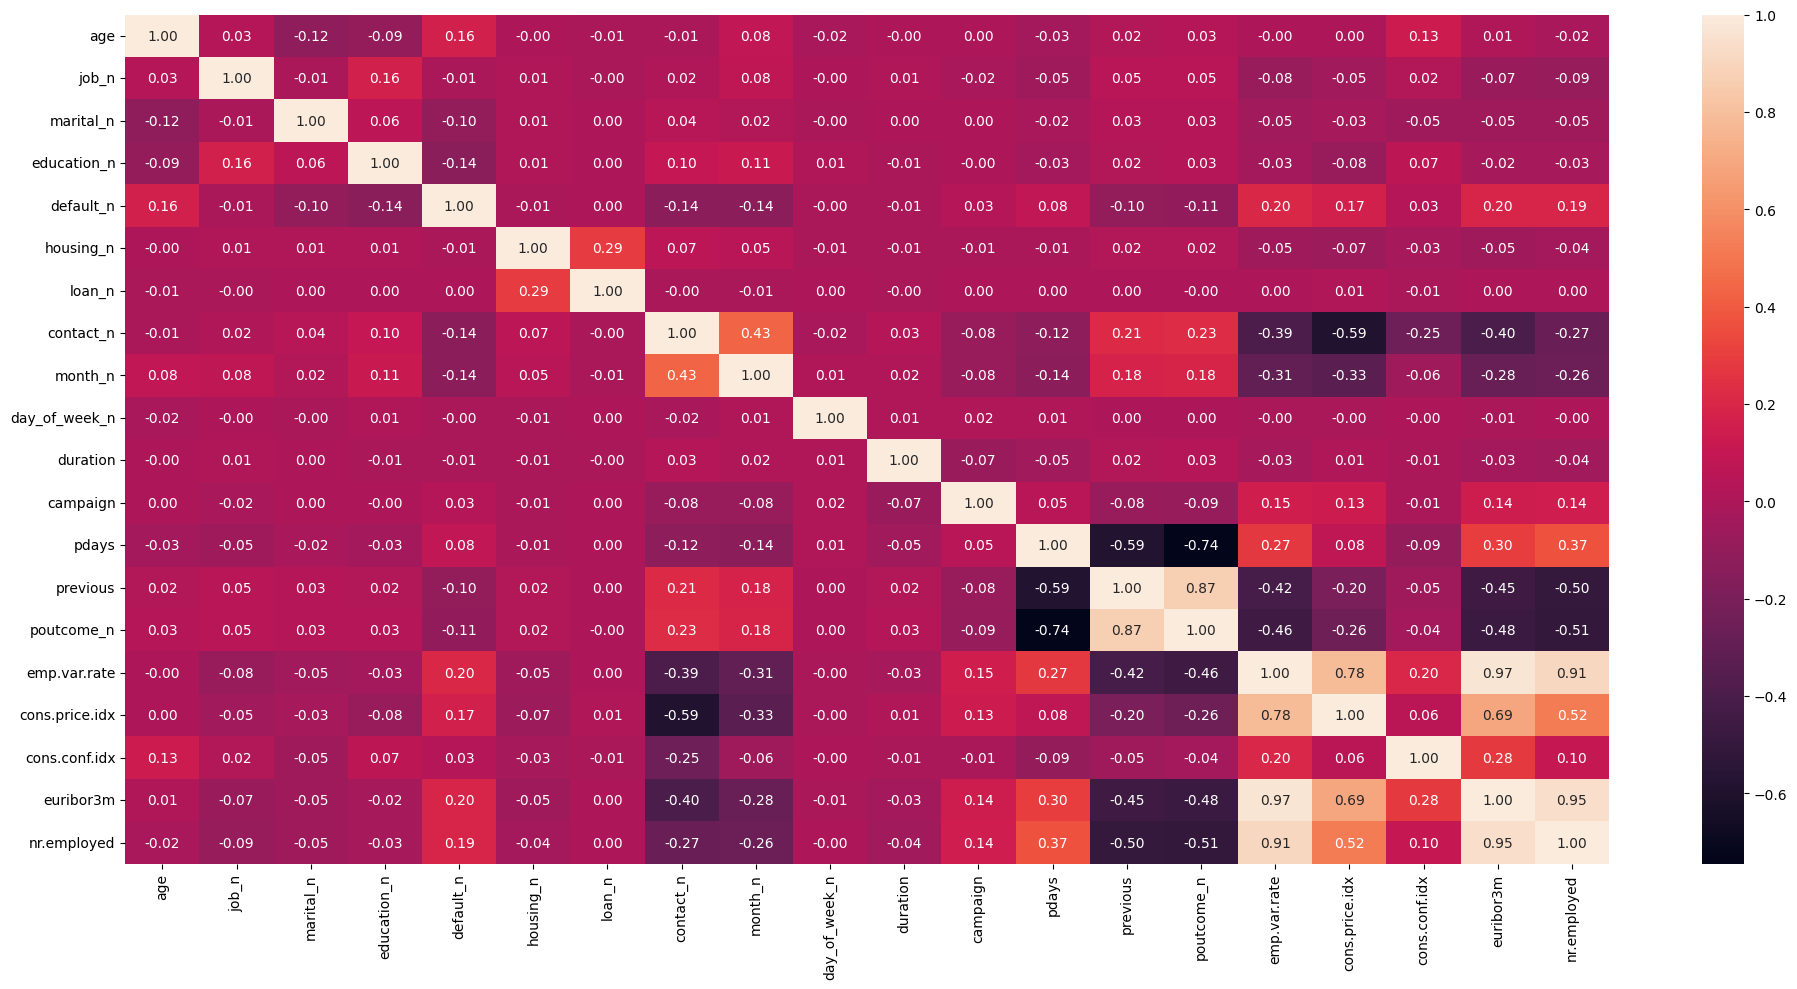

In [ ]:
fig, axis = plt.subplots(figsize=(20, 10))

sns.heatmap(
    raw_data[
        [
            "age",
            "job_n",
            "marital_n",
            "education_n",
            "default_n",
            "housing_n",
            "loan_n",
            "contact_n",
            "month_n",
            "day_of_week_n",
            "duration",
            "campaign",
            "pdays",
            "previous",
            "poutcome_n",
            "emp.var.rate",
            "cons.price.idx",
            "cons.conf.idx",
            "euribor3m",
            "nr.employed",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.tight_layout()

plt.show()

Based on the above, I'd assess:
- the strongest indicator of outcome is "previous," i.e. how many times the prospect was contacted in a previous campaign.  The second strongest is when & how the prospect was contacted.  Most other factors have much lower or no/negligible correelation.
- There are several unsurprising correlations which aren't directly relevant to the problem we're trying to solve.  For example, consumer confidence index & price index (approximations of macroeconomic activity/health) correlate to how many people the prospect has employed.

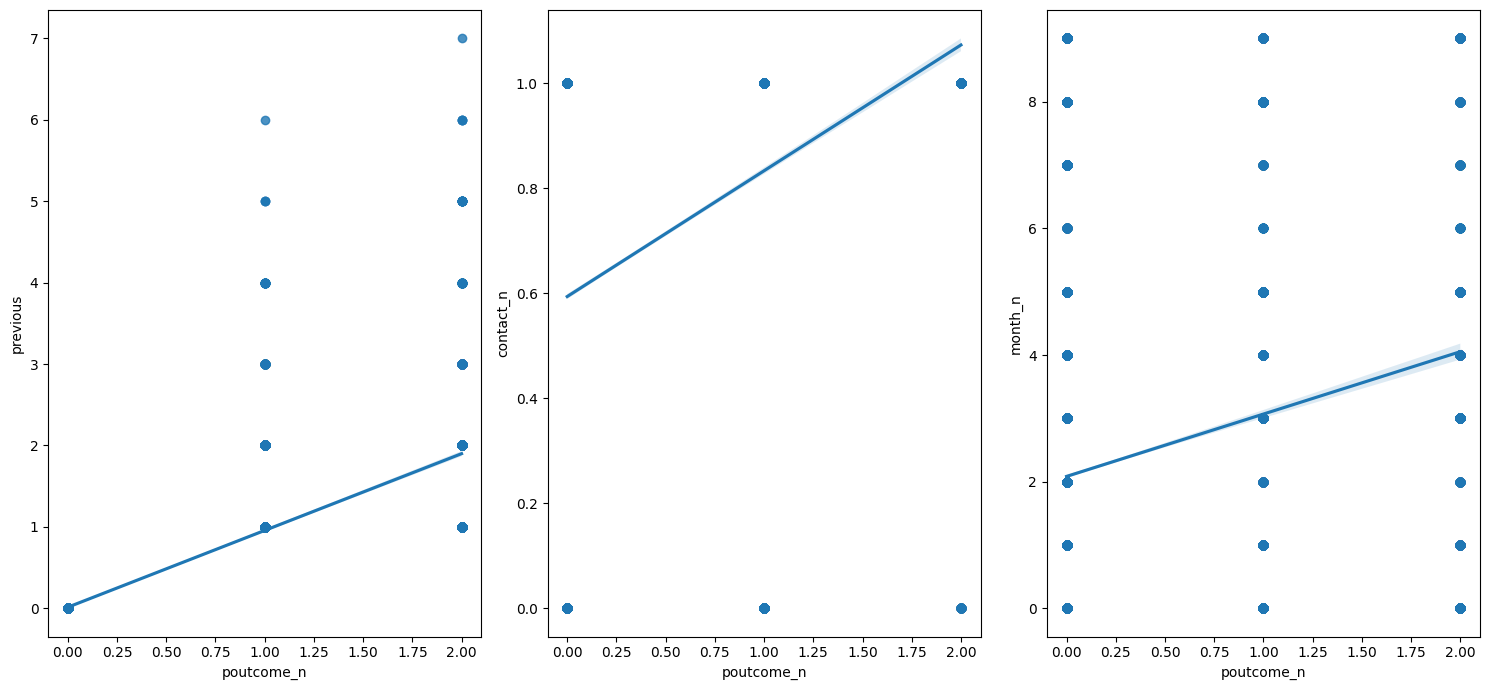

In [ ]:
fig, axis = plt.subplots(figsize=(15, 7), ncols=3)

sns.regplot(ax=axis[0], data=raw_data, x="poutcome_n", y="previous")
sns.regplot(ax=axis[1], data=raw_data, x="poutcome_n", y="contact_n")
sns.regplot(ax=axis[2], data=raw_data, x="poutcome_n", y="month_n")

plt.tight_layout()

plt.show()

Based on these regression plots:
- at first glance the visual slope for contact may make it look like the strongest-correlating variable, but the y scales differ across these plots, so actual slope of that one's shorter
- all three correlate to success/failure outcome


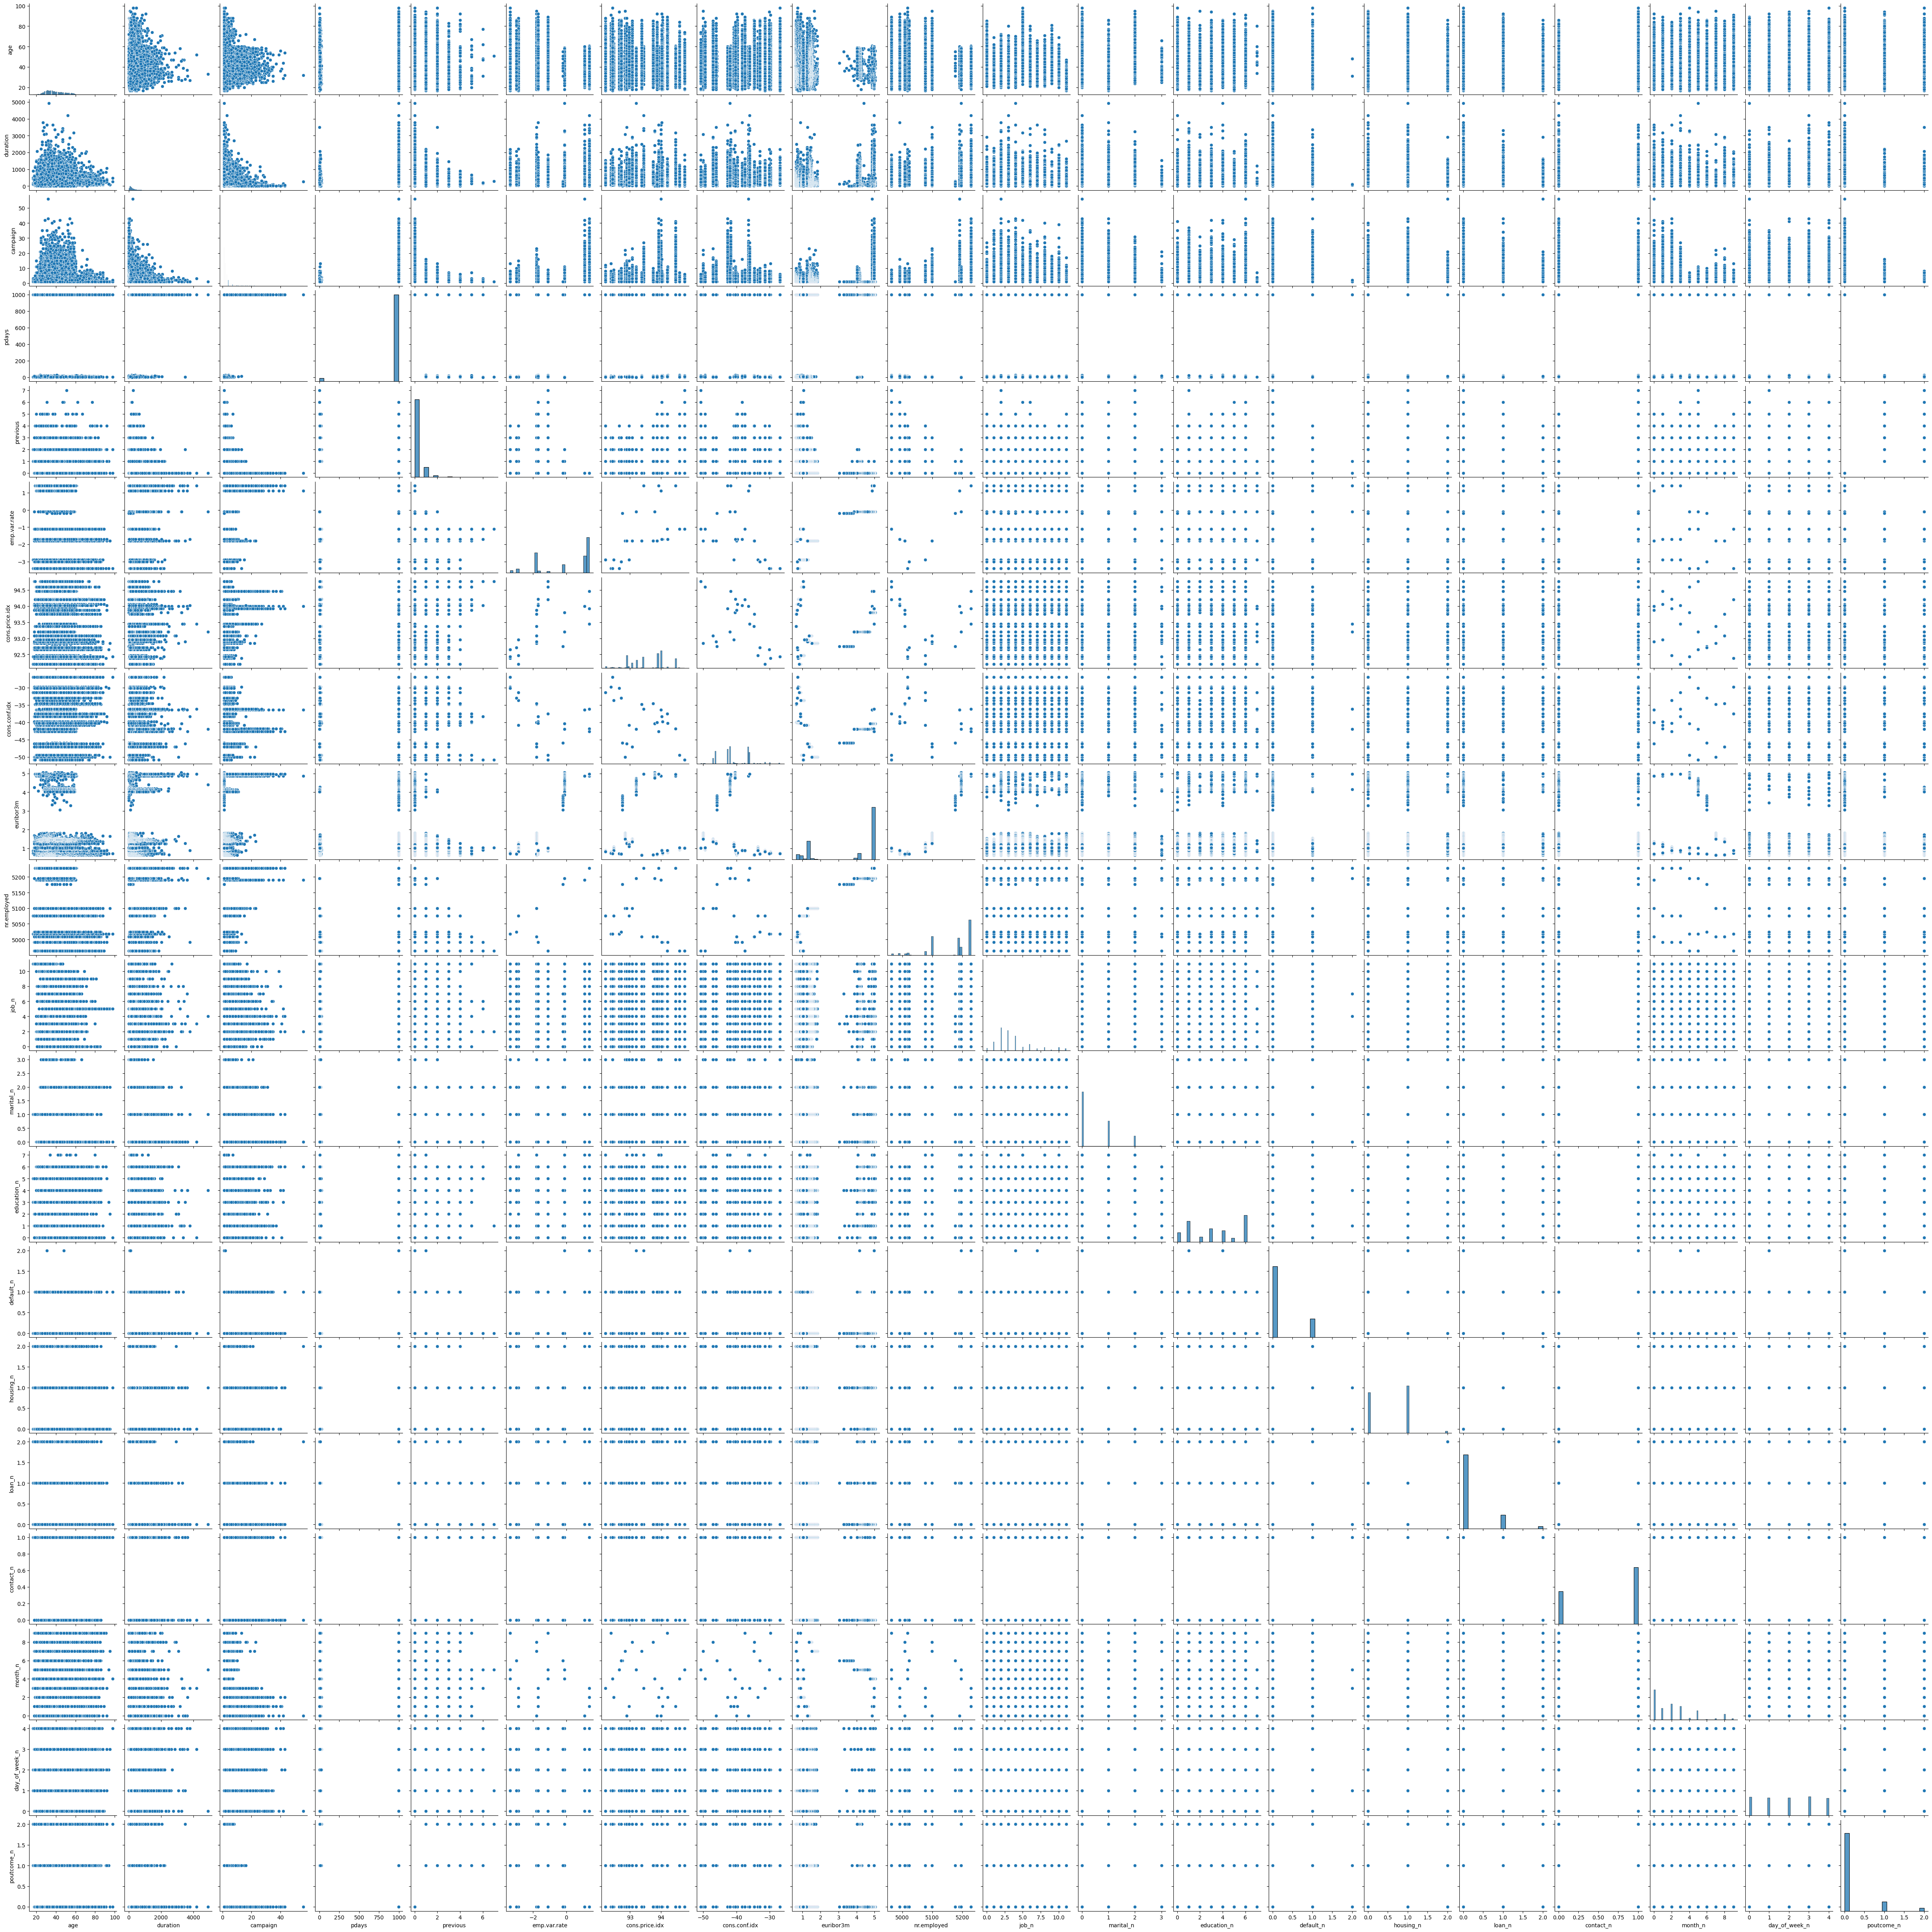

In [ ]:
sns.pairplot(data=raw_data)

In [ ]:
raw_data.describe()

age      duration      campaign         pdays      previous  \
count  41176.00000  41176.000000  41176.000000  41176.000000  41176.000000   
mean      40.02380    258.315815      2.567879    962.464810      0.173013   
std       10.42068    259.305321      2.770318    186.937102      0.494964   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m  \
count  41176.000000    41176.000000   41176.000000  41176.000000   
mean       0.081922       93.575720     -40.502863      3.621293   
std        1.570883        0.578839       4.627860      1.734437   
min       -3.400000       92.201000     -50.800000      0.634000   
25%       -1.800000       93.075000     -42.700000      1.344000   
50%        1.100000       93.749000     -41.800000      4.857000   
75%        1.400000       93.994000     -36.400000      4.961000   
max        1.400000       94.767000     -26.900000      5.045000   

        nr.employed         job_n     marital_n   education_n     default_n  \
count  41176.000000  41176.000000  41176.000000  41176.000000  41176.000000   
mean    5167.034870      3.673863      0.510637      3.277370      0.208908   
std       72.251364      2.454340      0.696794      2.185558      0.406713   
min     4963.600000      0.000000      0.000000      0.000000      0.000000   
25%     5099.100000      2.000000      0.000000      1.000000      0.000000   
50%     5191.000000      3.000000      0.000000      3.000000      0.000000   
75%     5228.100000      4.000000      1.000000      6.000000      0.000000   
max     5228.100000     11.000000      3.000000      7.000000      2.000000   

          housing_n        loan_n     contact_n       month_n  day_of_week_n  \
count  41176.000000  41176.000000  41176.000000  41176.000000   41176.000000   
mean       0.571959      0.199825      0.634714      2.249951       1.979600   
std        0.541216      0.456055      0.481516      2.429157       1.411539   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        0.000000      0.000000      0.000000      0.000000       1.000000   
50%        1.000000      0.000000      1.000000      2.000000       2.000000   
75%        1.000000      0.000000      1.000000      3.000000       3.000000   
max        2.000000      2.000000      1.000000      9.000000       4.000000   

         poutcome_n  
count  41176.000000  
mean       0.169953  
std        0.455811  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        2.000000

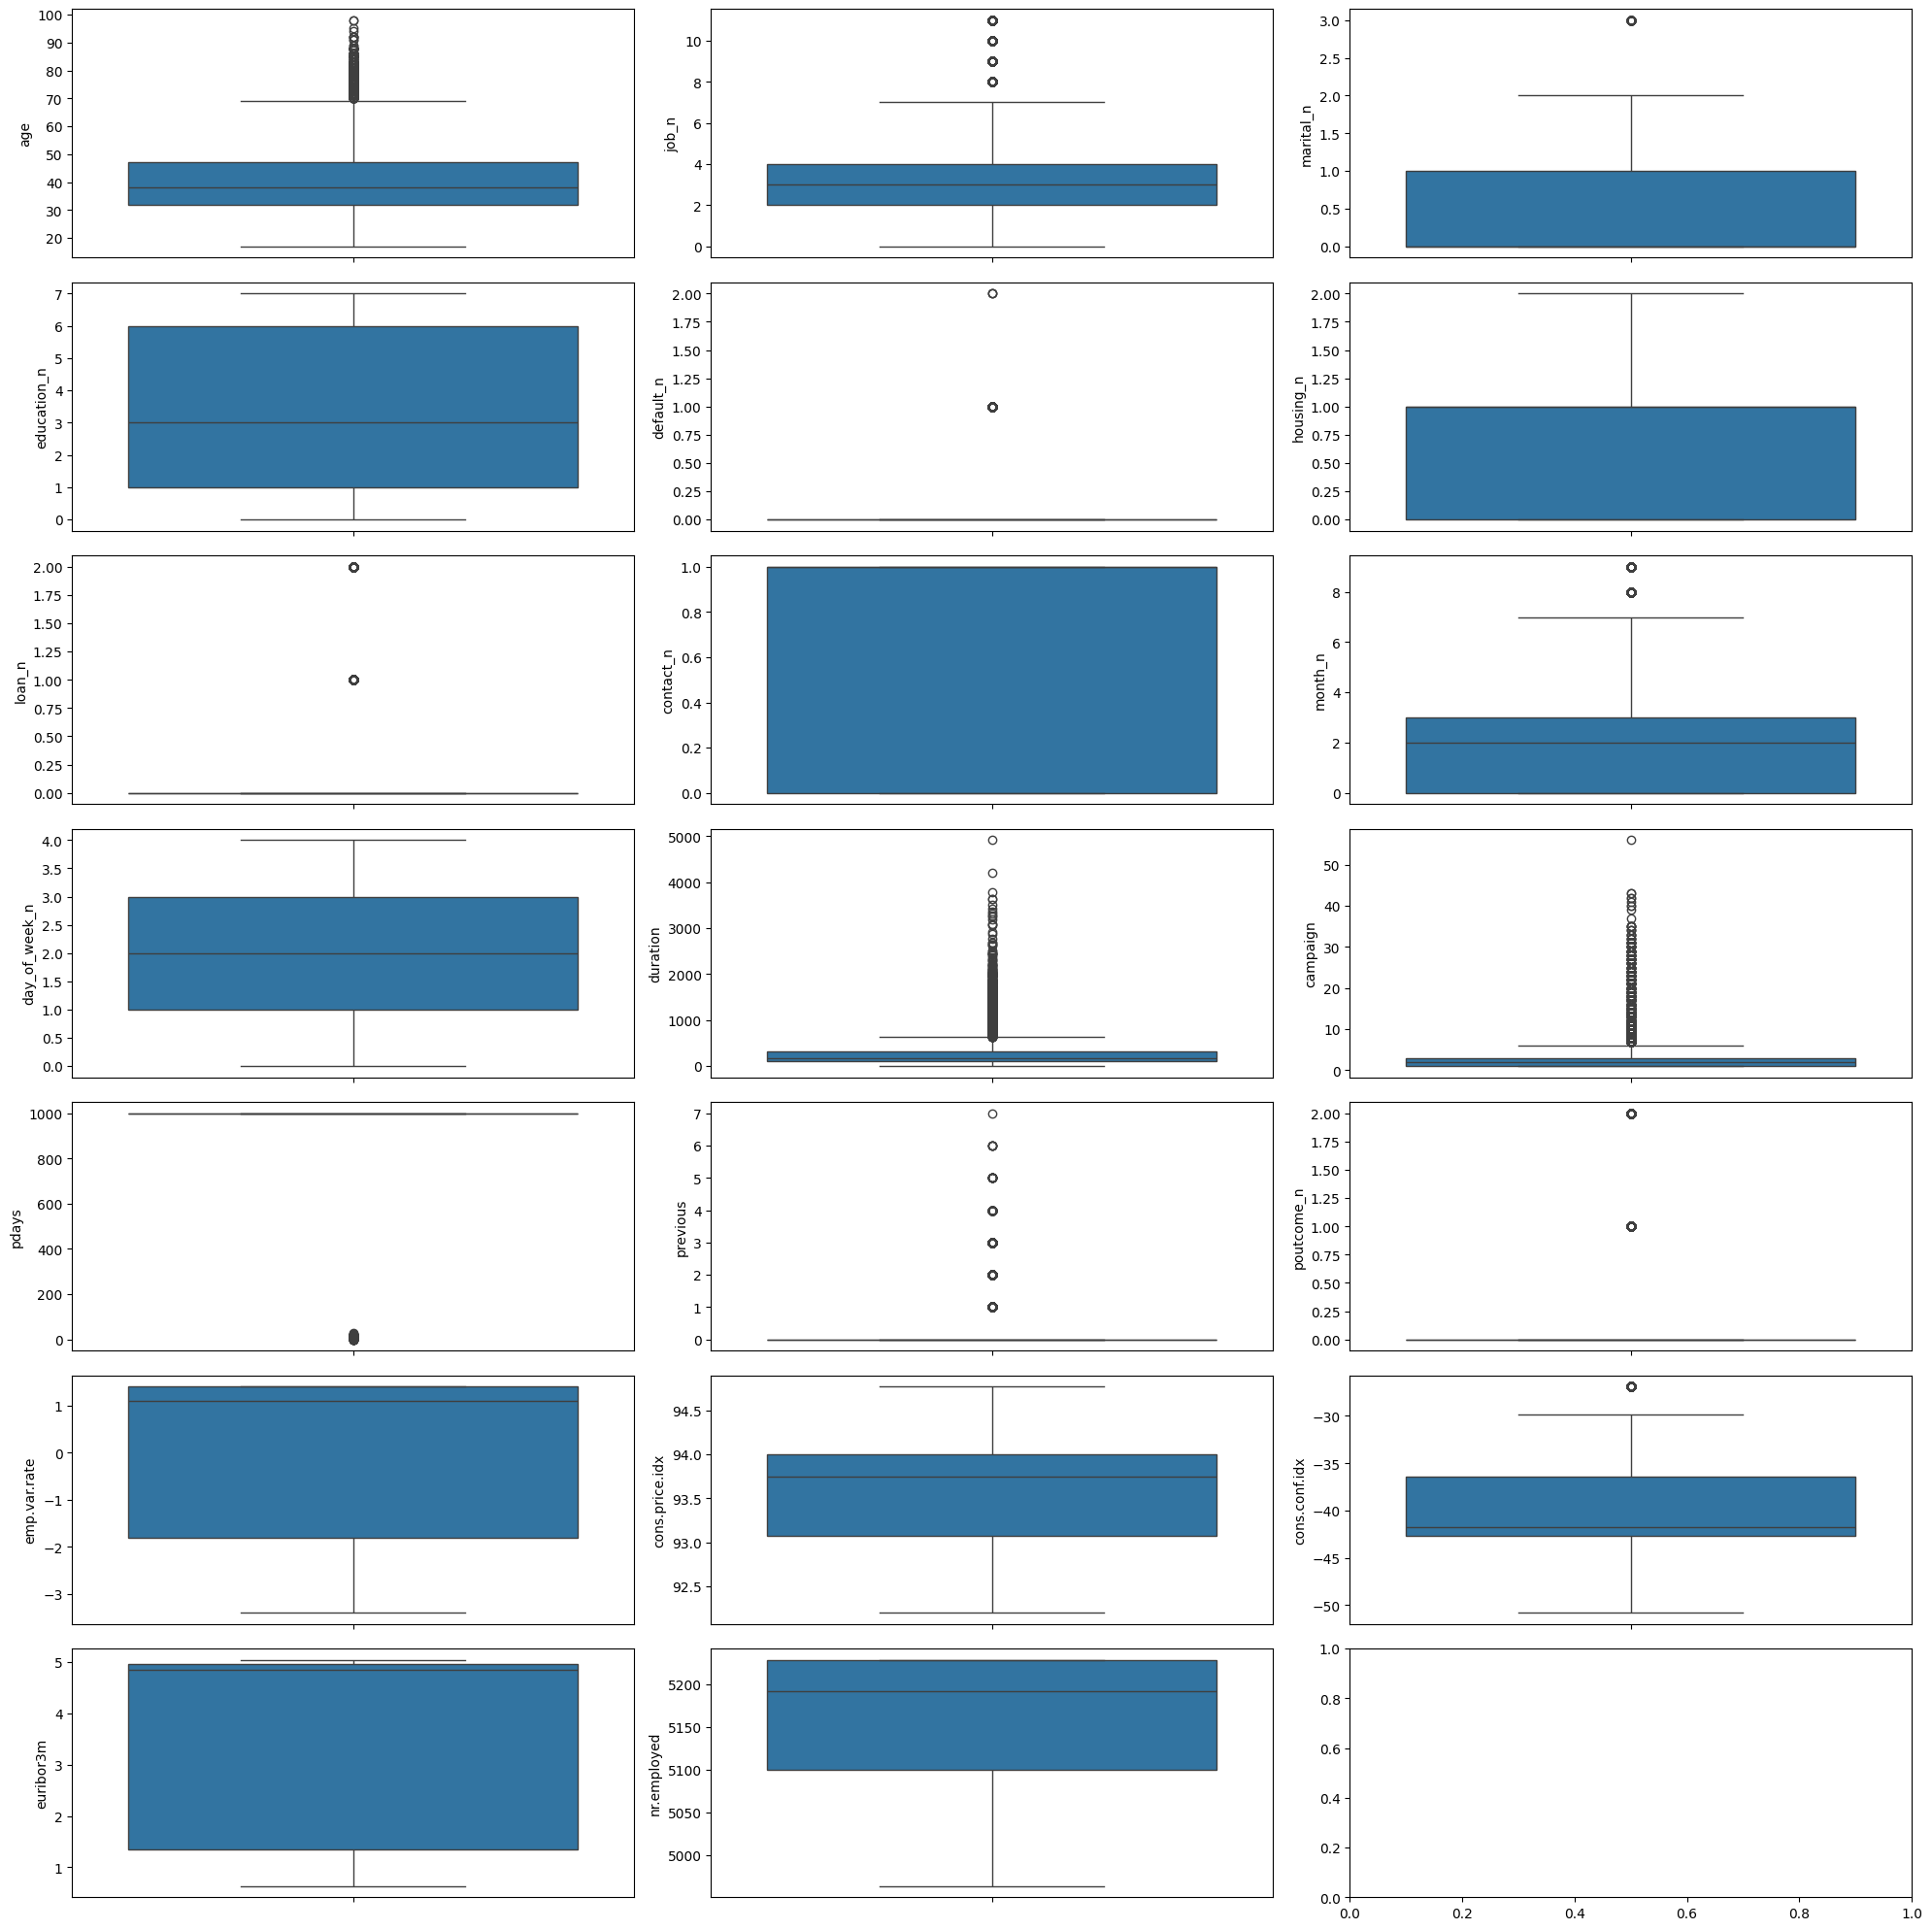

In [ ]:
fig, axis = plt.subplots(7, 3, figsize=(20, 20))

sns.boxplot(ax=axis[0, 0], data=raw_data, y="age")
sns.boxplot(ax=axis[0, 1], data=raw_data, y="job_n")
sns.boxplot(ax=axis[0, 2], data=raw_data, y="marital_n")
sns.boxplot(ax=axis[1, 0], data=raw_data, y="education_n")
sns.boxplot(ax=axis[1, 1], data=raw_data, y="default_n")
sns.boxplot(ax=axis[1, 2], data=raw_data, y="housing_n")
sns.boxplot(ax=axis[2, 0], data=raw_data, y="loan_n")
sns.boxplot(ax=axis[2, 1], data=raw_data, y="contact_n")
sns.boxplot(ax=axis[2, 2], data=raw_data, y="month_n")
sns.boxplot(ax=axis[3, 0], data=raw_data, y="day_of_week_n")
sns.boxplot(ax=axis[3, 1], data=raw_data, y="duration")
sns.boxplot(ax=axis[3, 2], data=raw_data, y="campaign")
sns.boxplot(ax=axis[4, 0], data=raw_data, y="pdays")
sns.boxplot(ax=axis[4, 1], data=raw_data, y="previous")
sns.boxplot(ax=axis[4, 2], data=raw_data, y="poutcome_n")
sns.boxplot(ax=axis[5, 0], data=raw_data, y="emp.var.rate")
sns.boxplot(ax=axis[5, 1], data=raw_data, y="cons.price.idx")
sns.boxplot(ax=axis[5, 2], data=raw_data, y="cons.conf.idx")
sns.boxplot(ax=axis[6, 0], data=raw_data, y="euribor3m")
sns.boxplot(ax=axis[6, 1], data=raw_data, y="nr.employed")

plt.tight_layout()

plt.show()

Items affected by outliers: age, job type, marital status, whether prospect is in default or has a personal loan, last month in which they've been contacted, length of call if over 500 seconds long, number of contacts in prior campaign (anything > around 5 is shown as an outlier), Number of days since alst contact, and consumer confidence index.

Maintain-eliminate-replace decisions: Age has enough data points listed in outliers that I wonder whether a separate analysis could be run for lower-aged vs. retiree-aged prospects.  Marital status outlier corresponds to divorcees, but this seems common enough (roughly 11%) that I'd keep it.  Consumer confidence index outlier seems isolated enough to drop.  Number of days since last contact has a clustered bit marked as an outlier but I remember that being charted as one of the most-relevant-seeming variables, so I wonder whether that cluster's important to keep.  Poutcome charted circles for "outliers" actually seem like the success/failure indicators we need as data to learn from, so am wondering whether I should've already separated out the "nonexistent" outcomes earlier in data cleaning (i.e. is nonexistint a synonym for Null / NaN or does it indicate a prospect has neither requeted nor rejected offers for services yet?)

In [ ]:
print(raw_data["cons.conf.idx"].describe())
outlier_threshold = -30  # picked approximately 80th percentile
atypical_cons_conf_idx = raw_data.query("`cons.conf.idx` > @outlier_threshold")
print(atypical_cons_conf_idx)
raw_data = raw_data.query(
    f"`cons.conf.idx` <= {outlier_threshold}"
)  # to drop the outlier rows

count    41176.000000
mean       -40.502863
std          4.627860
min        -50.800000
25%        -42.700000
50%        -41.800000
75%        -36.400000
max        -26.900000
Name: cons.conf.idx, dtype: float64
       age           job   marital          education  default housing loan  \
37887   53        admin.   married  university.degree  unknown     yes   no   
37888   32        admin.    single  university.degree       no     yes  yes   
37889   52        admin.   married            unknown       no      no   no   
37890   39  entrepreneur   married           basic.6y       no     yes   no   
37891   32        admin.    single  university.degree       no     yes   no   
...    ...           ...       ...                ...      ...     ...  ...   
38596   69       retired   married           basic.4y       no     yes  yes   
38597   18       student    single           basic.6y       no      no  yes   
38598   59       retired  divorced           basic.4y       no     yes   no  

In [ ]:
print(raw_data["campaign"].describe())
outlier_threshold = 50
atypical_campaign_value = raw_data.query(f"campaign > {outlier_threshold}")
print(atypical_campaign_value)
raw_data = raw_data.query(
    f"campaign <= {outlier_threshold}"
)  # to drop the outlier rows

count    40463.000000
mean         2.585275
std          2.788171
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64
      age     job  marital          education  default  housing     loan  \
4107   32  admin.  married  university.degree  unknown  unknown  unknown   

        contact month day_of_week  ...  job_n  marital_n  education_n  \
4107  telephone   may         mon  ...      2          0            6   

      default_n housing_n  loan_n  contact_n  month_n  day_of_week_n  \
4107          1         2       2          0        0              0   

      poutcome_n  
4107           0  

[1 rows x 31 columns]


In [ ]:
print(raw_data["duration"].describe())
outlier_threshold = 4000
atypical_duration = raw_data.query(f"duration > {outlier_threshold}")
print(atypical_duration)
raw_data = raw_data.query(
    f"duration <= {outlier_threshold}"
)  # to drop the outlier rows

count    40462.000000
mean       257.923558
std        259.102564
min          0.000000
25%        102.000000
50%        179.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64
       age          job  marital            education default housing loan  \
22192   52  blue-collar  married             basic.4y      no      no   no   
24091   33   technician   single  professional.course      no     yes   no   

         contact month day_of_week  ...  job_n  marital_n  education_n  \
22192  telephone   aug         thu  ...      3          0            0   
24091  telephone   nov         mon  ...      4          1            4   

       default_n housing_n  loan_n  contact_n  month_n  day_of_week_n  \
22192          0         0       0          0        3              3   
24091          0         1       0          0        5              0   

       poutcome_n  
22192           0  
24091           0  

[2 rows x 31 columns]


### Building logistic regression model

#### Feature scaling
##### Splitting training vs test data

In [ ]:
from sklearn.model_selection import train_test_split

num_variables = [
    "age",
    "job_n",
    "marital_n",
    "education_n",
    "default_n",
    "housing_n",
    "loan_n",
    "contact_n",
    "month_n",
    "day_of_week_n",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]


# We divide the dataset into training and test samples
X = raw_data.drop("poutcome_n", axis=1)[num_variables]
y = raw_data["poutcome_n"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.head()

age  job_n  marital_n  education_n  default_n  housing_n  loan_n  \
32140   38      2          0            1          0          1       0   
38791   66      5          0            0          0          1       1   
29839   34      2          0            3          0          1       0   
6201    50      1          0            2          0          0       0   
25293   41      4          1            4          1          1       0   

       contact_n  month_n  day_of_week_n  duration  campaign  pdays  previous  \
32140          1        0              4       213         5    999         0   
38791          0        5              3      1127         1    999         0   
29839          1        8              0       401         2    999         0   
6201           0        0              1       377         1    999         0   
25293          1        5              1        68         2      4         1   

       emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
32140          -1.8          92.893          -46.2      1.313       5099.1  
38791          -3.4          92.649          -30.1      0.714       5017.5  
29839          -1.8          93.075          -47.1      1.405       5099.1  
6201            1.1          93.994          -36.4      4.857       5191.0  
25293          -0.1          93.200          -42.0      4.153       5195.8

In [ ]:
# normalization scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=num_variables)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=num_variables)

X_train_norm.head()

age     job_n  marital_n  education_n  default_n  housing_n  \
32140 -0.184978 -0.679144  -0.738824    -1.043982  -0.516863   0.796144   
38791  2.551921  0.549525  -0.738824    -1.502403  -0.516863   0.796144   
29839 -0.575963 -0.679144  -0.738824    -0.127139  -0.516863   0.796144   
6201   0.987979 -1.088700  -0.738824    -0.585561  -0.516863  -1.055652   
25293  0.108261  0.139969   0.689831     0.331282   1.933315   0.796144   

         loan_n  contact_n   month_n  day_of_week_n  duration  campaign  \
32140 -0.439289   0.763253 -0.922330       1.432698 -0.173323  0.868251   
38791  1.762802  -1.310182  1.176781       0.725655  3.401828 -0.569087   
29839 -0.439289   0.763253  2.436248      -1.395476  0.562048 -0.209752   
6201  -0.439289  -1.310182 -0.922330      -0.688433  0.468171 -0.569087   
25293 -0.439289   0.763253  1.176781      -0.688433 -0.740496 -0.209752   

          pdays  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
32140  0.187119 -0.340099     -1.287543       -1.252000      -1.257623   
38791  0.187119 -0.340099     -2.345618       -1.686068       2.441139   
29839  0.187119 -0.340099     -1.287543       -0.928228      -1.464386   
6201   0.187119 -0.340099      0.630218        0.706643       0.993798   
25293 -5.355859  1.701126     -0.163338       -0.705857      -0.292728   

       euribor3m  nr.employed  
32140  -1.385809    -1.009614  
38791  -1.737106    -2.173948  
29839  -1.331854    -1.009614  
6201    0.692650     0.301688  
25293   0.279773     0.370178

In [ ]:
# min-max scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index=X_train.index, columns=num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index=X_test.index, columns=num_variables)

X_train_scal.head()

age     job_n  marital_n  education_n  default_n  housing_n  \
32140  0.269231  0.181818   0.000000     0.142857        0.0        0.5   
38791  0.628205  0.454545   0.000000     0.000000        0.0        0.5   
29839  0.217949  0.181818   0.000000     0.428571        0.0        0.5   
6201   0.423077  0.090909   0.000000     0.285714        0.0        0.0   
25293  0.307692  0.363636   0.333333     0.571429        0.5        0.5   

       loan_n  contact_n   month_n  day_of_week_n  duration  campaign  \
32140     0.0        1.0  0.000000           1.00  0.056275  0.095238   
38791     0.5        0.0  0.555556           0.75  0.297754  0.000000   
29839     0.0        1.0  0.888889           0.00  0.105945  0.023810   
6201      0.0        0.0  0.000000           0.25  0.099604  0.000000   
25293     0.0        1.0  0.555556           0.25  0.017966  0.023810   

          pdays  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
32140  1.000000  0.000000      0.333333        0.269680       0.222222   
38791  1.000000  0.000000      0.000000        0.174591       1.000000   
29839  1.000000  0.000000      0.333333        0.340608       0.178744   
6201   1.000000  0.000000      0.937500        0.698753       0.695652   
25293  0.004004  0.142857      0.687500        0.389322       0.425121   

       euribor3m  nr.employed  
32140   0.153933     0.512287  
38791   0.018136     0.203781  
29839   0.174790     0.512287  
6201    0.957379     0.859735  
25293   0.797778     0.877883

In [ ]:
# feature selection for selecting most-relevant features to use for building ML model

from sklearn.feature_selection import f_classif, SelectKBest

# With a value of k = 16 we implicitly mean that we want to remove 4 features from the 20-column dataset
selection_model = SelectKBest(f_classif, k=16)
selection_model.fit(X_train_scal, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(
    selection_model.transform(X_train), columns=X_train.columns.values[ix]
)
X_test_sel = pd.DataFrame(
    selection_model.transform(X_test), columns=X_test.columns.values[ix]
)

X_train_sel.head()

age  job_n  marital_n  education_n  default_n  contact_n  month_n  \
0  38.0    2.0        0.0          1.0        0.0        1.0      0.0   
1  66.0    5.0        0.0          0.0        0.0        0.0      5.0   
2  34.0    2.0        0.0          3.0        0.0        1.0      8.0   
3  50.0    1.0        0.0          2.0        0.0        0.0      0.0   
4  41.0    4.0        1.0          4.0        1.0        1.0      5.0   

   duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0     213.0       5.0  999.0       0.0          -1.8          92.893   
1    1127.0       1.0  999.0       0.0          -3.4          92.649   
2     401.0       2.0  999.0       0.0          -1.8          93.075   
3     377.0       1.0  999.0       0.0           1.1          93.994   
4      68.0       2.0    4.0       1.0          -0.1          93.200   

   cons.conf.idx  euribor3m  nr.employed  
0          -46.2      1.313       5099.1  
1          -30.1      0.714       5017.5  
2          -47.1      1.405       5099.1  
3          -36.4      4.857       5191.0  
4          -42.0      4.153       5195.8

In [ ]:
X_train_sel["poutcome_n"] = list(y_train)
X_test_sel["poutcome_n"] = list(y_test)

In [ ]:
X_train_sel.to_csv(
    "../data/interim/clean_banking_marketing_campaign.csv",
    index=False,
)
X_test_sel.to_csv("../data/interim/clean_banking_marketing_campaign.csv", index=False)

In [ ]:
import pandas as pd

train_data = pd.read_csv("../data/interim/clean_banking_marketing_campaign.csv")
test_data = pd.read_csv("../data/interim/clean_banking_marketing_campaign.csv")

train_data.head()

age  job_n  marital_n  education_n  default_n  contact_n  month_n  \
0  50.0    3.0        0.0          0.0        0.0        1.0      0.0   
1  30.0    6.0        1.0          1.0        0.0        1.0      0.0   
2  50.0    3.0        0.0          0.0        1.0        0.0      0.0   
3  59.0    1.0        0.0          1.0        0.0        1.0      8.0   
4  41.0    4.0        0.0          4.0        0.0        1.0      8.0   

   duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0     197.0       2.0  999.0       0.0          -1.8          92.893   
1     402.0       2.0  999.0       0.0          -1.8          92.893   
2     100.0       1.0  999.0       0.0           1.1          93.994   
3     542.0       3.0  999.0       1.0          -1.8          93.075   
4     466.0       5.0  999.0       1.0          -1.8          93.075   

   cons.conf.idx  euribor3m  nr.employed  price  poutcome_n  
0          -46.2      1.299       5099.1      0           0  
1          -46.2      1.334       5099.1      0           0  
2          -36.4      4.856       5191.0      0           0  
3          -47.1      1.453       5099.1      1           1  
4          -47.1      1.423       5099.1      1           1

In [ ]:
X_train = train_data.drop(["poutcome_n"], axis=1)
y_train = train_data["poutcome_n"]
X_test = test_data.drop(["poutcome_n"], axis=1)
y_test = test_data["poutcome_n"]

In [ ]:
from sklearn.linear_model import LogisticRegression

model_using_plain_default_hyperparams = LogisticRegression()
model_using_plain_default_hyperparams.fit(X_train, y_train)

c:\Users\Nick\git\logistic-regression-project-tutorial-NWinocur\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = model_using_plain_default_hyperparams.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(8092,))

#### Accuracy score without hyperparameter optimization

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8947108255066732

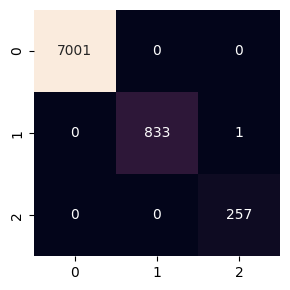

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

bank_marketing_co_matr = confusion_matrix(y_test, y_pred)

# Let's draw this matrix to make it more visual
cm_df = pd.DataFrame(bank_marketing_co_matr)

plt.figure(figsize=(3, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)

plt.tight_layout()

plt.show()

In [ ]:
model_using_higher_max_iterations = LogisticRegression(max_iter=100000)
model_using_higher_max_iterations.fit(X_train, y_train)
y_pred = model_using_higher_max_iterations.predict(X_test)
y_pred
accuracy_score(y_test, y_pred)

0.999876421156698

Three-nines accuracy in less than 25 seconds of processing time made this better in terms of both accuracy and computational intensity vs. just jumping straight to trying hyperparameter tuning on an otherwise-default model.

#### Hyperparameter optimizing
##### Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

# We define the parameters that we want to adjust by hand
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}

# We initialize the grid
grid = GridSearchCV(
    model_using_plain_default_hyperparams, hyperparams, scoring="accuracy", cv=5
)
grid

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [ ]:
def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'C': 0.001, 'penalty': None, 'solver': 'newton-cg'}


In [ ]:
model_grid = LogisticRegression(penalty="l1", C=10, solver="liblinear")
model_grid.fit(X_train, y_train)
y_pred = model_grid.predict(X_test)

grid_accuracy = accuracy_score(y_test, y_pred)
grid_accuracy

0.9962926347009392

Two-nines accuracy is substantially better than sub-90, and is better than random search finds in cells below.  But needing to take about 3 minutes 43 seconds to get it seems not worthwhile to me vs. just upping the max iterations on the plain model enough to get three nines in less time.

##### Random search hyperparameter optimization-hunting

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# We define the parameters we want to adjust
hyperparams = {
    "C": np.logspace(-4, 4, 20),
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}

# We initialize the random search
random_search = RandomizedSearchCV(
    model_using_plain_default_hyperparams,
    hyperparams,
    n_iter=100,
    scoring="accuracy",
    cv=5,
    random_state=42,
)
random_search

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, scoring='accuracy')

In [ ]:
random_search.fit(X_train, y_train)

print(f"Best hyperparameters: {random_search.best_params_}")

c:\Users\Nick\git\logistic-regression-project-tutorial-NWinocur\.venv\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\Nick\git\logistic-regression-project-tutorial-NWinocur\.venv\Lib\site-packages\sklearn\utils\optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


Best hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': np.float64(10000.0)}


In [ ]:
model_random_search = LogisticRegression(penalty="l2", C=29.7635, solver="lbfgs")
model_random_search.fit(X_train, y_train)
y_pred = model_random_search.predict(X_test)

random_search_accuracy = accuracy_score(y_test, y_pred)
random_search_accuracy

0.8952051408798813

89.52% accuracy is better than 89.47%, barely, but still not as good as either upping max iteration on an otherwise-default model, or the hyperparameters found by grid search above.